In [ ]:
from dask.distributed import Client
client = Client(n_workers=24, threads_per_worker=1, processes=True, memory_limit='48GB')
client

2025-11-11 16:15:00,411 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,413 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,413 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,414 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,415 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,416 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,417 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 48GB due to system memory limit of 32.00 GiB
2025-11-11 16:15:00,418 - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 768.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57399,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 768.00 GiB
Comm: tcp://127.0.0.1:57450,Total threads: 1
Dashboard: http://127.0.0.1:57463/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:57402,


2025-11-11 17:16:01,740 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 13 memory: 121 MB fds: 522>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
  File "/opt/anaconda3/lib/python3.13/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
  File "/opt/anaconda3/lib/python3.13/site-packages/psutil/__init__.py", line 2117, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2025-11-11 23:26:04,107 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 15 memory: 145 MB fds: 522>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
  File "/opt/anaconda3/lib/python

In [2]:
import os
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import geopandas as gpd
import warnings
from glob import glob
from tqdm import tqdm
from zipfile import ZipFile
from scipy.stats import pearsonr, kurtosis, skew, moment, normaltest, levene, ttest_ind, norm
from scipy.interpolate import interp1d
import statsmodels.formula.api as smf
from shapely.geometry import Polygon
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dask.dataframe as dd
import dask
import polars as pl
import matplotlib.gridspec as gridspec

# Plotting settings
import scienceplots
import matplotlib
STYLE = ['science', 'nature']

# Suppress warnings
pd.options.mode.chained_assignment = None  # Suppress chained assignment warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set environment variable for Bokeh logging
os.environ['BOKEH_LOG_LEVEL'] = 'fatal'
%matplotlib inline

In [3]:
# 1. Synchronous Audio-Video Telehealth Visits (Office/Outpatient E/M)
synchronous_telehealth = [
    "99201", "99202", "99203", "99204", "99205",   # New‐patient
    "99211", "99212", "99213", "99214", "99215"    # Established‐patient
]

# 2. Virtual Check-In (asynchronous brief patient‐initiated)
virtual_check_in = [
    "G2010",  # Evaluation of recorded video/images
    "G2012",  # Brief communication technology–based service (5–10 min)
    "98966",  # Non‐face‐to‐face telephone by clinical staff (5–10 min)
    "98967",  # … (11–20 min)
    "98968",  # … (21–30 min)
    "G2252",  # Brief communication tech‐based e/M service, established patient
]

# 3. Asynchronous Online Digital E/M (“E-Visits”)
digital_evisits = [
    "99421",  # 5–10 min cumulative over 7 days
    "99422",  # 11–20 min
    "99423",  # 21+ min
]

# 4. Telephone-Only E/M (Audio-Only)
telephone_e_m = [
    "99441",  # 5–10 min
    "99442",  # 11–20 min
    "99443",  # 21–30 min
]

# 5. Remote Physiologic Monitoring (RPM)
rpm = [
    "99453",  # Initial set-up & patient education
    "99454",  # Device supply w/ recordings, per 30 days
    "99091",  # Collection & interpretation (30+ min)
    "99457",  # Treatment management, first 20 min
    "99458",  # Additional 20 min
]

# 6. Remote Therapeutic Monitoring (RTM)
rtm = [
    "98975",  # Initial device set-up & training
    "98976",  # Device supply & collection (musculoskeletal)
    "98977",  # Device supply & collection (respiratory)
    "98980",  # Management services, first 20 min
    "98981",  # Each additional 20 min
]

# 7. Interprofessional Internet Consults (“e-Consults”)
interprofessional_consults = [
    "99446",  # 5–10 min
    "99447",  # 11–20 min
    "99448",  # 21–30 min
    "99449",  # 31+ min
    "99451",  # Physician review & report (5+ min)
    "99452",  # Referring-provider discussion (30 min)
]

# 8. Behavioral Health Integration & Collaborative Care
behavioral_health_integration = [
    "99492",  # Initial psychiatric collaborative care (70 min)
    "99493",  # Subsequent psychiatric collaborative care (60 min)
    "99494",  # Initial care management time by consultative clinician
]

# 9. Chronic & Principal Care Management
chronic_care_management = [
    "99490",  # 20+ min clinical staff time/month
]
principal_care_management = [
    "99424",  # Initial 30 min principal care
    "99425",  # Each additional 30 min
]

# 10. Common Telehealth Modifiers & POS
telehealth_modifiers = ["95", "GT", "GQ"]  # append to CPT to flag telehealth
# telehealth_pos = ["02"]                   # Place-of-Service code for telehealth

# New AMA Synchronous Audio-Video E/M Codes for 2025 (Not adopted by CMS for Medicare E/M billing)
ama_new_synchronous_audio_video_em_2025 = ['98000', '98001', '98002', '98003', 
                                           '98004', '98005', '98006', '98007']

# New AMA Synchronous Audio-Only E/M Codes for 2025 (Replace 99441-99443; Not adopted by CMS for Medicare E/M billing)
ama_new_synchronous_audio_only_em_2025 = ['98008', '98009', '98010', '98011', 
                                          '98012', '98013', '98014', '98015']

# New AMA Brief Communication Technology-Based Service Code for 2025 (Replaces G2012; Adopted by CMS)
ama_new_brief_communication_tech_2025 = ['98016']

# Standard Office/Outpatient E/M Codes Used for Medicare Telehealth Billing in 2025 (with Modifiers 95/93 and POS 02/10)
cms_preferred_telehealth_em_office_outpatient_2025 = ['99202', '99203', '99204', '99205', 
                                                      '99211', '99212', '99213', '99214', '99215']

# CMS Telehealth Subsequent Inpatient Visit Codes for 2025 (Frequency limits suspended by CMS through Dec 31, 2025)
cms_telehealth_inpatient_subsequent_visit_2025 = ['99231', '99232', '99233']

# CMS Telehealth Subsequent Nursing Facility Visit Codes for 2025 (Frequency limits suspended by CMS through Dec 31, 2025)
cms_telehealth_nursing_facility_subsequent_visit_2025 = ['99307', '99308', '99309', '99310']

# CMS Telehealth Critical Care Consultation HCPCS Codes for 2025 (Frequency limits suspended by CMS through Dec 31, 2025)
cms_telehealth_critical_care_consult_hcpcs_2025 = ['G0508', 'G0509']

# Asynchronous Online Digital E/M Service Codes for Physician/QHP for 2025
asynchronous_online_digital_em_physician_qhp_2025 = ['99421', '99422', '99423']

# Asynchronous Online Digital Assessment & Management Service Codes for Non-Physician QHP for 2025
# (Verify payer coverage; CMS active, some commercial payers may not cover)
asynchronous_online_digital_em_non_physician_qhp_2025 = ['98970', '98971', '98972']

# Remote Physiologic Monitoring (RPM) CPT Codes for 2025
# (Includes general RPM and specific Self-Measured Blood Pressure codes often managed similarly)
remote_physiologic_monitoring_rpm_2025 = ['99091', '99453', '99454', '99457', '99458', 
                                           '99473', '99474']

# Remote Therapeutic Monitoring (RTM) CPT Codes for 2025
# (98975, 98976-98978 revised for 2025)
remote_therapeutic_monitoring_rtm_2025 = ['98975', '98976', '98977', '98978', 
                                          '98980', '98981']

# Interprofessional Telephone/Internet/EHR Consultation CPT Codes for 2025
interprofessional_consultations_2025 = ['99446', '99447', '99448', '99449', 
                                        '99451', '99452']

# Interprofessional Behavioral Health Consultation HCPCS Codes for 2025 (New for CMS)
interprofessional_consultations_behavioral_health_hcpcs_2025 = ['G0546', 'G0547', 'G0548', 
                                                                  'G0549', 'G0550', 'G0551']

# Chronic Care Management (CCM) CPT Codes for 2025 (Often involve telehealth delivery)
care_management_ccm_2025 = ['99490', '99491', '99437', '99439', 
                              '99487', '99489']

# Principal Care Management (PCM) CPT Codes for 2025 (Often involve telehealth delivery)
care_management_pcm_2025 = ['99424', '99425', '99426', '99427']

# Behavioral Health Integration (BHI) & Collaborative Care Management (CoCM) CPT/HCPCS Codes for 2025 (Often involve telehealth delivery)
care_management_bhi_cocm_2025 = ['99484', '99492', '99493', '99494', 
                                 'G2214', 'G0323']

# Telephone Services by Non-Physician Healthcare Professionals CPT Codes for 2025
# (Active in CPT, but payer coverage varies significantly; CMS generally non-covered for ongoing use post-PHE)
telephone_services_non_physician_2025 = ['98966', '98967', '98968']

# Key Telehealth-Related CPT/HCPCS Codes Deleted or Replaced for 2025
# deleted_telehealth_related_codes_2025 = # Replaced by CPT 98016

# # Common Telehealth Modifiers for 2025 (Usage depends on payer and service)
# telehealth_modifiers_2025 =  # Acute Stroke Telehealth

# Key Telehealth Place of Service (POS) Codes for 2025 (Primarily for CMS)
# telehealth_pos_codes_2025 =  # Telehealth Provided in Patient’s Home

all_codes = synchronous_telehealth+virtual_check_in+digital_evisits+telephone_e_m+rpm+rtm+interprofessional_consults+\
behavioral_health_integration+chronic_care_management+principal_care_management+telehealth_modifiers+\
ama_new_synchronous_audio_video_em_2025+ama_new_synchronous_audio_only_em_2025+ama_new_brief_communication_tech_2025+\
cms_preferred_telehealth_em_office_outpatient_2025+cms_telehealth_inpatient_subsequent_visit_2025+\
cms_telehealth_nursing_facility_subsequent_visit_2025+cms_telehealth_critical_care_consult_hcpcs_2025+\
asynchronous_online_digital_em_physician_qhp_2025+asynchronous_online_digital_em_non_physician_qhp_2025+\
remote_physiologic_monitoring_rpm_2025+remote_therapeutic_monitoring_rtm_2025+\
interprofessional_consultations_2025+interprofessional_consultations_behavioral_health_hcpcs_2025+\
care_management_ccm_2025+care_management_pcm_2025+care_management_bhi_cocm_2025+telephone_services_non_physician_2025

all_codes = np.unique(all_codes)
len(all_codes)

95

- Synchronous “video” visits are captured by the E/M codes above (99201–99215) when billed with POS = 02 or modifier = 95/GT.
- Audio-only telephony uses the telephone-only E/M codes (99441–99443) or virtual check-in codes (98966–98968) depending on who’s providing the service.
- Asynchronous digital E-visits (99421–99423) and virtual check-ins (G2010/G2012) are separate categories—be sure to include both.
- RPM/RTM and interprofessional consults each have their own code sets—include these if your research question encompasses monitoring and specialist-to-specialist teleconsults.
- Behavioral health integration and care management codes capture care-coordination services often delivered remotely.

In [4]:
base_dir = '/home/asadr/datasets/TriNetX/dataset_64b01b62c6dca15375ae9828_stroke/'
for fil_ in glob(f'{base_dir}*.csv'):
    cols = dd.read_csv(fil_).columns.to_list()
    print(fil_.split('/')[-1].replace('.csv',''))
    print(cols)

patient
['patient_id', 'sex', 'race', 'ethnicity', 'marital_status', 'year_of_birth', 'reason_yob_missing', 'age_at_death', 'postal_code']
oncology_treatment
['patient_id', 'diagnosis_date', 'tumor_site_code_system', 'tumor_site_code', 'morphology_code_system', 'morphology_code', 'oncology_treatment_start_date', 'oncology_treatment_code_system', 'oncology_treatment_code', 'derived_by_TriNetX']
procedure
['patient_id', 'code_system', 'code', 'principal_procedure_indicator', 'date', 'derived_by_TriNetX']
standardized_terminology
['code_system', 'code', 'code_description', 'path', 'unit']
dataset_details
['total_number_unique_patients', 'total_number_HCOs', 'date_created', 'network_name']
vitals_signs
['patient_id', 'code_system', 'code', 'date', 'value', 'text_value', 'units_of_measure', 'derived_by_TriNetX']
tumor_properties
['patient_id', 'diagnosis_date', 'observation_date', 'tumor_site_code_system', 'tumor_site_code', 'morphology_code_system', 'morphology_code', 'tumor_property_code_

In [5]:
df_px = dd.read_csv(f'{base_dir}procedure.csv', dtype='object')[
['patient_id','code','date']
].rename(columns={'code':'code_px','date':'date_px'})
df_px['date_px'] = dd.to_datetime(df_px['date_px'], format='%Y%m%d')
# df_px['date_px'] = dd.to_datetime(df_px['date_px'], format='%Y%m%d')

stroke_depression = dd.read_parquet('mental/stroke_depression.parquet')
stroke_depression['stroke_date'] = dd.to_datetime(stroke_depression['stroke_date'], format='%Y%m%d')
# stroke_depression['stroke_date'] = dd.to_datetime(stroke_depression['stroke_date'], format='%Y%m%d')

# 2. Merge on patient_id
df_px = df_px.merge(stroke_depression[['patient_id', 'stroke_date']], on='patient_id', how='inner')

# 3. Filter only rows where procedure date is after stroke date
df_px = df_px[df_px['date_px'] > df_px['stroke_date']]

df_px['telehealth_flag'] = df_px['code_px'].str.contains('|'.join(all_codes), regex=True)
df_px = df_px[df_px['telehealth_flag']]

# Build reverse lookup with containment (handle suffixes/modifiers)
import numpy as np
# Define code-to-category mapping
from collections import defaultdict

# Flatten your lists with categories
category_dict = {
    "synchronous_audio_video": synchronous_telehealth + ama_new_synchronous_audio_video_em_2025 + cms_preferred_telehealth_em_office_outpatient_2025,
    "audio_only": telephone_e_m + ama_new_synchronous_audio_only_em_2025 + telephone_services_non_physician_2025,
    "virtual_check_in": virtual_check_in + ama_new_brief_communication_tech_2025,
    "digital_evisit": digital_evisits + asynchronous_online_digital_em_physician_qhp_2025 + asynchronous_online_digital_em_non_physician_qhp_2025,
    "remote_monitoring_rpm": rpm + remote_physiologic_monitoring_rpm_2025,
    "remote_monitoring_rtm": rtm + remote_therapeutic_monitoring_rtm_2025,
    "interprofessional_consult": interprofessional_consults + interprofessional_consultations_2025 + interprofessional_consultations_behavioral_health_hcpcs_2025,
    "behavioral_health": behavioral_health_integration + care_management_bhi_cocm_2025,
    "care_management": chronic_care_management + care_management_ccm_2025 + principal_care_management + care_management_pcm_2025,
    "inpatient_telehealth": cms_telehealth_inpatient_subsequent_visit_2025 + cms_telehealth_nursing_facility_subsequent_visit_2025 + cms_telehealth_critical_care_consult_hcpcs_2025
}

# Invert to code -> category
code_to_category = {}
for category, code_list in category_dict.items():
    for code in code_list:
        code_to_category[code] = category

# Define a function to map code to category
def get_telehealth_category(code):
    return code_to_category.get(code, None)

def match_category(code):
    for base_code, category in code_to_category.items():
        if base_code in code:
            return category
    return None

# Apply to your dataframe
# df_px['telehealth_category'] = df_px['code_px'].map(get_telehealth_category)
df_px['telehealth_category'] = df_px['code_px'].apply(
    match_category, meta=('telehealth_category', 'object')
)
# df_px = df_px[df_px['telehealth_category'].notna()]

df_px = df_px.compute()

df_px.columns

Index(['patient_id', 'code_px', 'date_px', 'stroke_date', 'telehealth_flag',
       'telehealth_category'],
      dtype='object')

In [7]:
df_px.shape
# 145249375 

(108748830, 6)

In [9]:
df_px['stroke2px'] = (df_px['date_px'] - df_px['stroke_date']).dt.days

In [11]:
print(df_px.shape)
df_px.head(2)

(108748830, 7)


,patient_id,code_px,date_px,stroke_date,telehealth_flag,telehealth_category,stroke2px
2106,Vw5I,99204,2019-04-04,2018-08-28,True,synchronous_audio_video,219
2107,Vw5I,99204,2019-04-04,2018-08-28,True,synchronous_audio_video,219


In [12]:
df_px_win = df_px[df_px['stroke2px']<=180]
print(df_px_win.shape)
df_px_win.head(2)

(37133222, 7)


,patient_id,code_px,date_px,stroke_date,telehealth_flag,telehealth_category,stroke2px
2232,Vw5I,99214,2018-11-13,2018-08-28,True,synchronous_audio_video,77
2233,Vw5I,99214,2018-11-13,2018-08-28,True,synchronous_audio_video,77


In [22]:
df_nthpp = df_px_win[['patient_id','telehealth_category','code_px']].groupby(
    ['patient_id','telehealth_category']
).count().rename(columns={'code_px':'n_px'}).reset_index()

In [23]:
df_nthpp.head(2)

,patient_id,telehealth_category,n_px
0,#A##D,inpatient_telehealth,5
1,#A##D,synchronous_audio_video,1


In [26]:
columns_ = ["synchronous_audio_video", "audio_only", "virtual_check_in", "digital_evisit", "remote_monitoring_rpm", 
            "remote_monitoring_rtm", "interprofessional_consult", "behavioral_health", "care_management", "inpatient_telehealth"]
df_nthpp = df_nthpp.pivot(columns='telehealth_category',index='patient_id',values='n_px').fillna(0)

In [28]:
print(df_nthpp.shape)
df_nthpp.head(2)

(447381, 9)


telehealth_category,audio_only,behavioral_health,care_management,digital_evisit,inpatient_telehealth,interprofessional_consult,remote_monitoring_rpm,synchronous_audio_video,virtual_check_in
patient_id,,,,,,,,,
#A##D,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0
#A#1,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0


In [43]:
df_nthpp.reset_index()['patient_id'].nunique()
# 447381 

447381

In [44]:
df_nthpp = pd.read_parquet('telehealth/df_nthpp.parquet').reset_index()
df_nthpp.head(2)

telehealth_category,patient_id,audio_only,behavioral_health,care_management,digital_evisit,inpatient_telehealth,interprofessional_consult,remote_monitoring_rpm,synchronous_audio_video,virtual_check_in
0,#A##D,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0
1,#A#1,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0


In [46]:
# df_nthpp.mean()

In [30]:
# df_nthpp.to_parquet('telehealth/df_nthpp.parquet')

In [129]:
df_nthpp = dd.read_parquet('telehealth/df_nthpp.parquet').reset_index()

In [130]:
patient = dd.read_csv(f'{base_dir}patient.csv',
    dtype={
        'patient_id': 'object',
        'sex': 'object',
        'race': 'object',
        'ethnicity': 'object',
        'marital_status': 'object',
        'year_of_birth': 'float64',        # allows NaN
        'reason_yob_missing': 'object',
        'age_at_death': 'float64',         # if missing values exist
        'postal_code': 'object'            # ZIPs can be strings, sometimes missing
    }, assume_missing=True)
# 9. Join with demographics
demographics = patient[['patient_id', 'sex', 'race', 'ethnicity', 'year_of_birth','postal_code']]
cohort = df_nthpp.merge(demographics, on='patient_id', how='left').compute()
print(cohort.shape)

(447381, 15)


In [131]:
stroke_depression = pd.read_parquet('mental/stroke_depression.parquet')
stroke_depression['stroke_date'] = pd.to_datetime(stroke_depression['stroke_date'], format='%Y%m%d')
stroke_depression = stroke_depression[['patient_id','stroke_date']].drop_duplicates()
cohort = cohort.merge(stroke_depression, on='patient_id', how='left')
print(cohort.shape)
cohort.head(3)

(447381, 16)


,patient_id,audio_only,behavioral_health,care_management,digital_evisit,inpatient_telehealth,interprofessional_consult,remote_monitoring_rpm,synchronous_audio_video,virtual_check_in,sex,race,ethnicity,year_of_birth,postal_code,stroke_date
0,#A#2D,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,F,Unknown,Unknown,1961.0,926,2018-07-03
1,#A#ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,M,Unknown,Unknown,1951.0,XXX,2018-11-20
2,#A#b,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,F,Unknown,Unknown,NaN,112,2015-11-12


In [132]:
cohort.head(10)

,patient_id,audio_only,behavioral_health,care_management,digital_evisit,inpatient_telehealth,interprofessional_consult,remote_monitoring_rpm,synchronous_audio_video,virtual_check_in,sex,race,ethnicity,year_of_birth,postal_code,stroke_date
0,#A#2D,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,F,Unknown,Unknown,1961.0,926,2018-07-03
1,#A#ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,M,Unknown,Unknown,1951.0,XXX,2018-11-20
2,#A#b,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,F,Unknown,Unknown,NaN,112,2015-11-12
3,#A#gC,0.0,0.0,0.0,0.0,15.0,0.0,0.0,240.0,0.0,M,Unknown,Unknown,1962.0,852,2016-04-15
4,#A#q,0.0,0.0,0.0,0.0,100.0,0.0,0.0,12.0,0.0,F,Unknown,Unknown,1930.0,XXX,2014-11-04
5,#A#rC,0.0,0.0,0.0,0.0,338.0,0.0,0.0,0.0,0.0,F,Unknown,Unknown,1960.0,XXX,2018-06-12
6,#A#uB,0.0,0.0,0.0,0.0,36.0,0.0,0.0,144.0,0.0,M,Unknown,Unknown,1947.0,376,2017-04-12
7,#A0GD,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,F,Unknown,Unknown,1964.0,774,2013-03-31
8,#A0JC,0.0,0.0,0.0,0.0,296.0,0.0,0.0,0.0,0.0,M,Unknown,Unknown,1930.0,XXX,2015-04-19
9,#A14C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,F,Unknown,Unknown,1975.0,776,2018-05-31


In [139]:
cohort.shape

(447381, 16)

In [134]:
df_ruca = pd.read_csv('../sus/stroke/insurance_data/RUCA2010zipcode_2020.csv', dtype={"ZIP_CODE": str})
df_ruca[df_ruca['ZIP_CODE']=='17033'] # Here in Hershey

,ZIP_CODE,STATE,ZIP_TYPE,RUCA1,RUCA2
6462,17033,PA,Zip Code Area,1,1.0


In [143]:
df_ruca = pd.read_csv('../sus/stroke/insurance_data/RUCA2010zipcode_2020.csv', dtype={"ZIP_CODE": str})
df_ruca['ZIP_CODE'] = df_ruca['ZIP_CODE'].apply(lambda x:str(x)[:3])
df_ruca['ZIP_CODE'] = df_ruca['ZIP_CODE'].astype(str).str.zfill(3)
df_ruca['RUCA1'] = df_ruca['RUCA1'].replace({99:np.nan})
df_ruca = df_ruca[['ZIP_CODE','STATE','RUCA1']].dropna()
df_ruca_avg = df_ruca.groupby('ZIP_CODE')['RUCA1'].mean().to_frame().reset_index()

df_ruca_avg.head(3)

,ZIP_CODE,RUCA1
0,000,7.041667
1,001,6.886364
2,005,1.000000


In [145]:
cohort = cohort.merge(df_ruca_avg,left_on='postal_code',right_on='ZIP_CODE',how='left')

In [156]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Load cohort
# cohort = cohort.compute() if hasattr(cohort, "compute") else cohort.copy()

# Derive age at stroke
# cohort['stroke_date'] = pd.to_datetime(cohort['stroke_date'])
cohort['age_at_stroke'] = cohort['stroke_date'].dt.year - cohort['year_of_birth']
cohort['age_group'] = pd.cut(cohort['age_at_stroke'], bins=[0, 64, 74, 120], labels=['<65', '65–74', '75+'])

cohort['RUCA_group'] = pd.cut(cohort['RUCA1'], bins=[0, 2, 4, 11], labels=['0-2', '2-4', '>4'])

# Optional: drop NaNs for clean visualization
cohort_full = cohort.dropna(subset=['sex', 'race', 'ethnicity', 'age_group'])
cohort_full.shape

(411538, 21)

<Axes: >

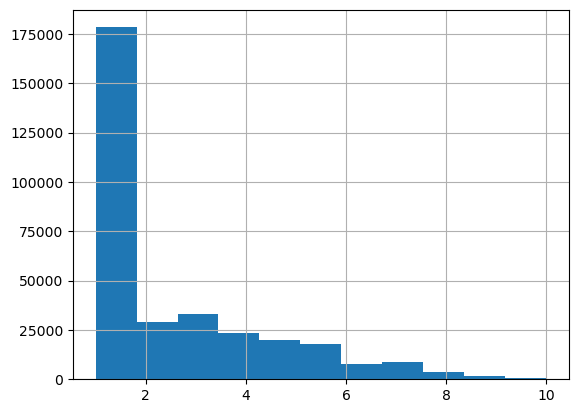

In [155]:
cohort_full['RUCA1'].hist(bins=11)

In [160]:
# Define TH modality columns
th_cols = [
    'audio_only', 'behavioral_health', 'care_management', 'digital_evisit',
    'inpatient_telehealth', 'interprofessional_consult',
    'remote_monitoring_rpm', 'synchronous_audio_video', 'virtual_check_in'
]

# Convert wide to long format
cohort_long = cohort_full.melt(
    id_vars=['patient_id', 'sex', 'race', 'ethnicity', 'age_group', 'RUCA_group'],
    value_vars=th_cols,
    var_name='telehealth_modality',
    value_name='count'
)

# Keep only non-zero usage
cohort_long = cohort_long[cohort_long['count'] > 0]


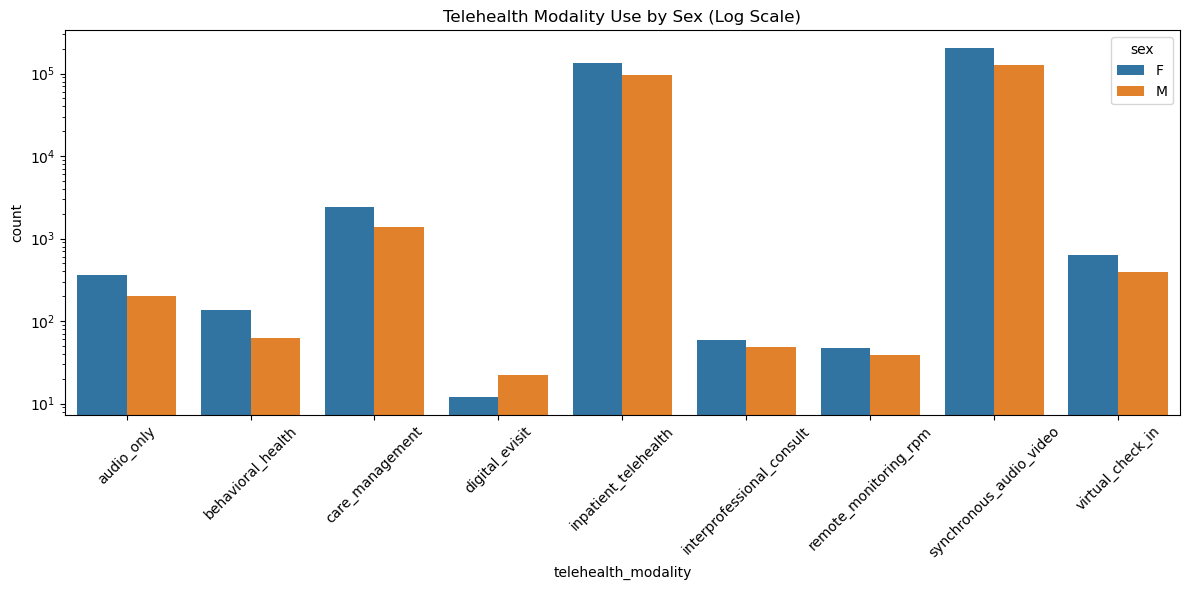

In [161]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# 

# Set up figure with log-scaled y-axis
plt.figure(figsize=(12, 6))
sns.countplot(data=cohort_long, x='telehealth_modality', hue='sex')
plt.yscale('log')
plt.title('Telehealth Modality Use by Sex (Log Scale)')
plt.xticks(rotation=45)
plt.tight_layout()

/tmp/ipykernel_447908/2979175113.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_filter)


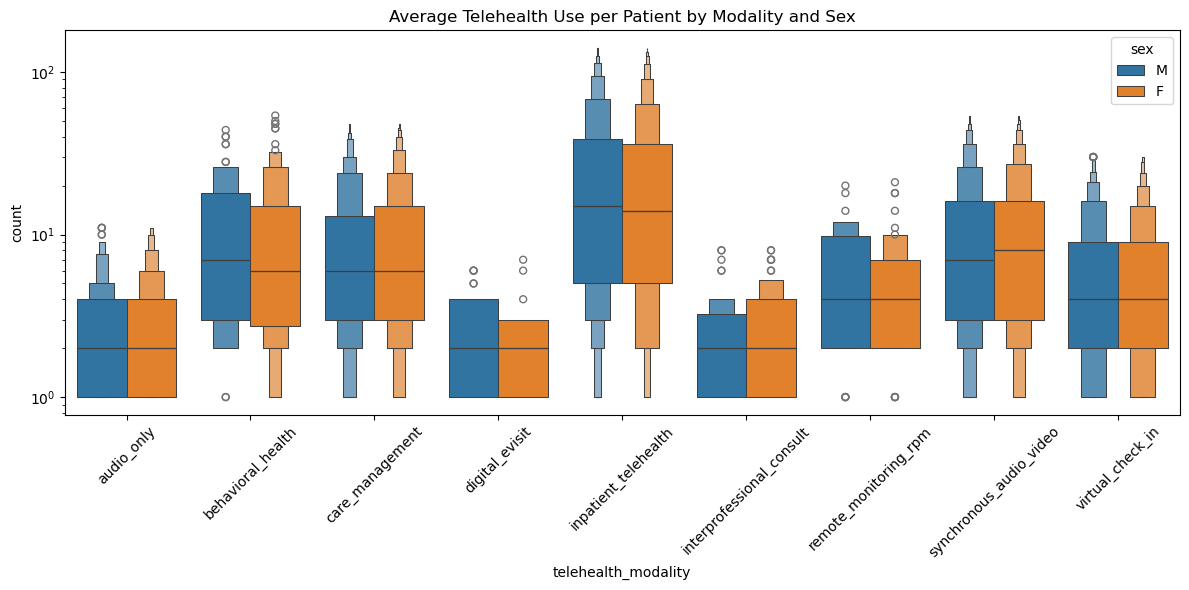

In [162]:
# Compute per-patient total per modality
cohort_wide = cohort_long.groupby(['patient_id', 'sex', 'telehealth_modality'])['count'].mean().reset_index()

def remove_outliers_iqr(df, group_col, value_col):
    def _filter(group):
        q1 = group[value_col].quantile(0.25)
        q3 = group[value_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
    
    return df.groupby(group_col, group_keys=False).apply(_filter)

cohort_wide = remove_outliers_iqr(cohort_wide, 'telehealth_modality', 'count')

# Create boxenplot of usage by sex
plt.figure(figsize=(12, 6))
sns.boxenplot(data=cohort_wide, x='telehealth_modality', y='count', hue='sex')
plt.yscale('log')
plt.title('Average Telehealth Use per Patient by Modality and Sex')
plt.xticks(rotation=45)
plt.tight_layout()

In [163]:
cohort_wide[cohort_wide['telehealth_modality']=='inpatient_telehealth']#['count'].mean()

,patient_id,sex,telehealth_modality,count
0,#A##D,F,inpatient_telehealth,5.0
2,#A#1C,M,inpatient_telehealth,2.0
4,#A#2D,F,inpatient_telehealth,45.0
7,#A#5,F,inpatient_telehealth,20.0
8,#A#6D,F,inpatient_telehealth,9.0
...,...,...,...,...
570099,zwzbB,F,inpatient_telehealth,6.0
570101,zwzbC,F,inpatient_telehealth,24.0
570105,zwzg,F,inpatient_telehealth,39.0
570108,zwzlC,M,inpatient_telehealth,66.0


In [164]:
from scipy.stats import mannwhitneyu
# Compute p-values (Mann-Whitney U test) for each modality
modality_pvals = {}
for modality in cohort_wide['telehealth_modality'].unique():
    male_counts = cohort_wide[(cohort_wide['telehealth_modality'] == modality) & (cohort_wide['sex'] == 'M')]['count']
    female_counts = cohort_wide[(cohort_wide['telehealth_modality'] == modality) & (cohort_wide['sex'] == 'F')]['count']
    if len(male_counts) > 0 and len(female_counts) > 0:
        stat, p = mannwhitneyu(male_counts, female_counts, alternative='two-sided')
        modality_pvals[modality] = p

# Format p-values for display
pval_df = pd.DataFrame(list(modality_pvals.items()), columns=['Modality', 'Mann-Whitney p-value']).sort_values(by='Mann-Whitney p-value')
# import ace_tools as tools; tools.display_dataframe_to_user(name="P-values by Modality", dataframe=pval_df)
pval_df.round(4)

,Modality,Mann-Whitney p-value
4,inpatient_telehealth,0.0000
7,synchronous_audio_video,0.0000
2,care_management,0.1943
1,behavioral_health,0.3574
0,audio_only,0.5355
5,interprofessional_consult,0.6754
6,remote_monitoring_rpm,0.7362
8,virtual_check_in,0.7368
3,digital_evisit,0.7518


/tmp/ipykernel_447908/2650522257.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_filter)


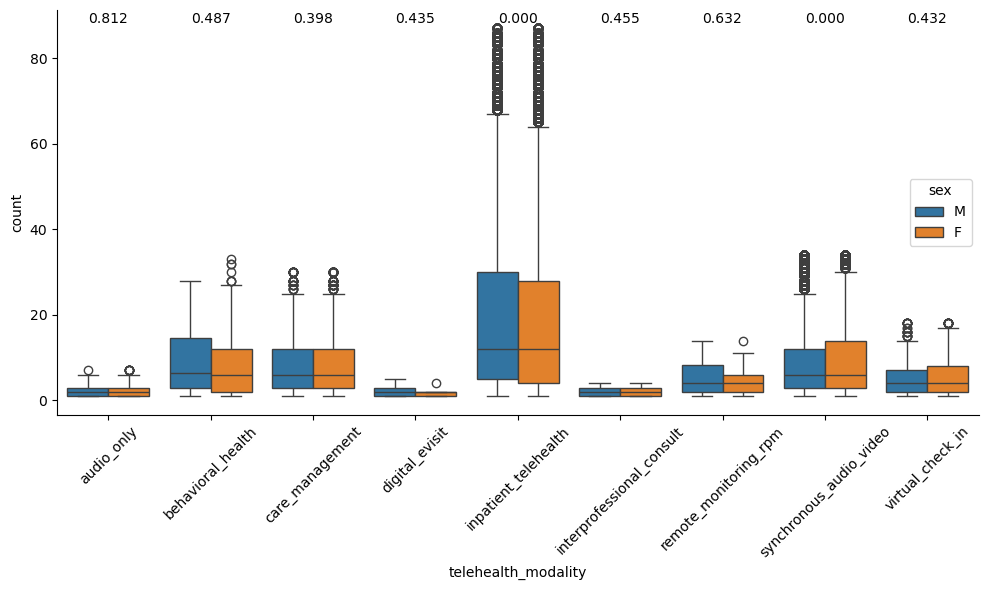

/tmp/ipykernel_447908/2650522257.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_filter)


1


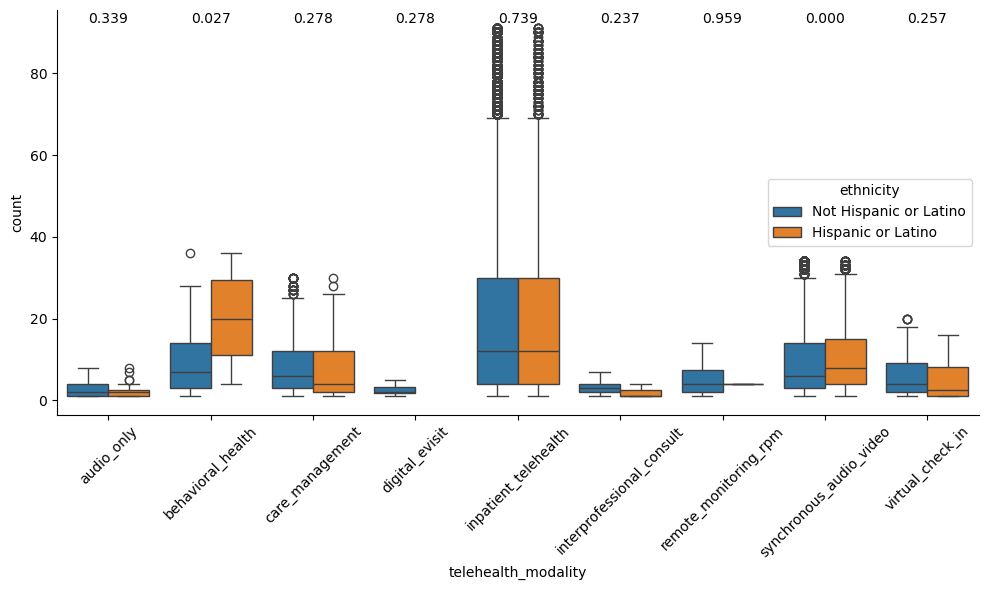

/tmp/ipykernel_447908/2650522257.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_filter)


1


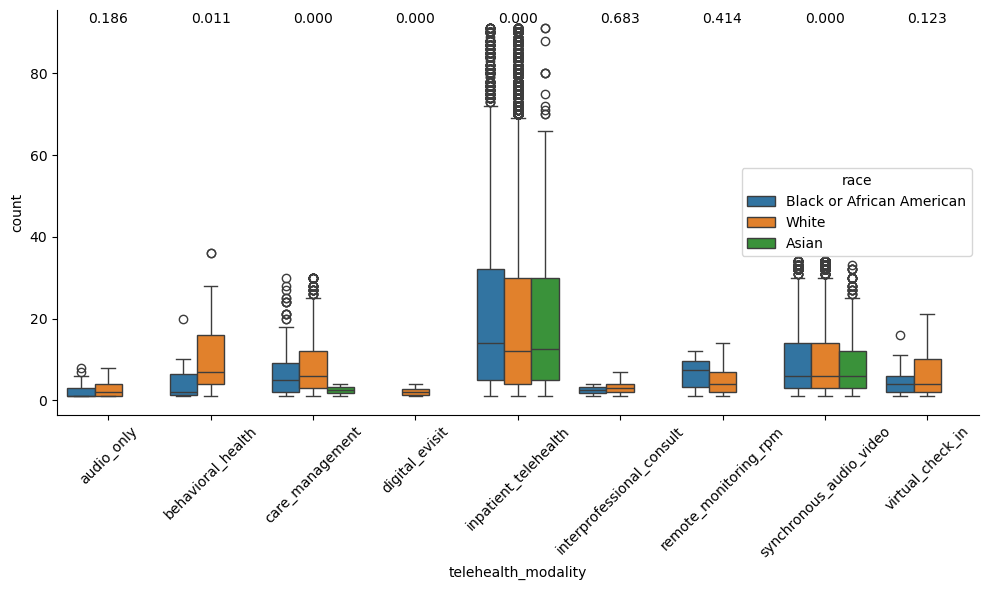

/tmp/ipykernel_447908/2650522257.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_wide = cohort_long.groupby(['patient_id', col_, 'telehealth_modality'])['count'].mean().reset_index()
/tmp/ipykernel_447908/2650522257.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_filter)


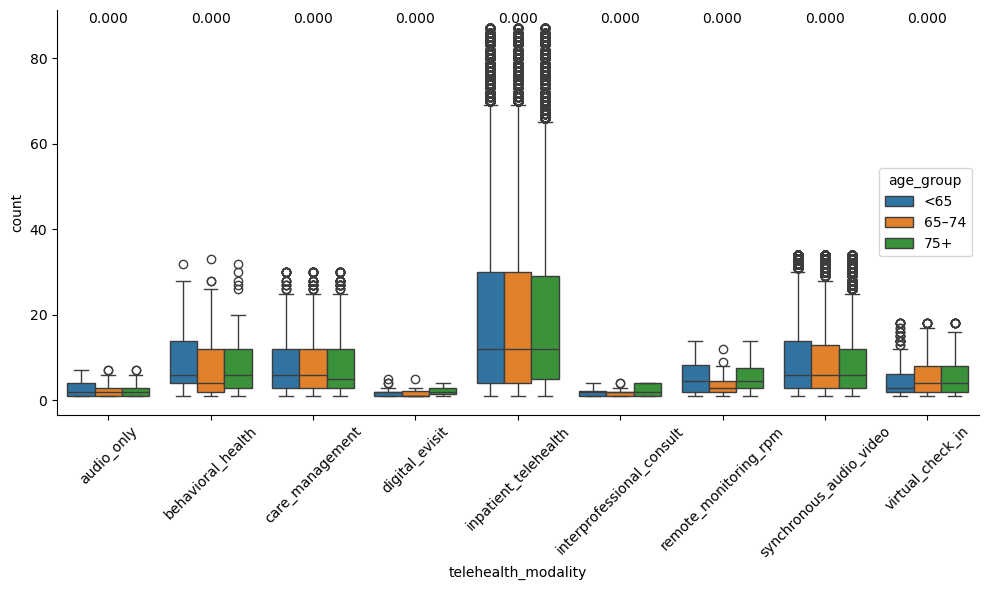

/tmp/ipykernel_447908/2650522257.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_wide = cohort_long.groupby(['patient_id', col_, 'telehealth_modality'])['count'].mean().reset_index()
/tmp/ipykernel_447908/2650522257.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_filter)


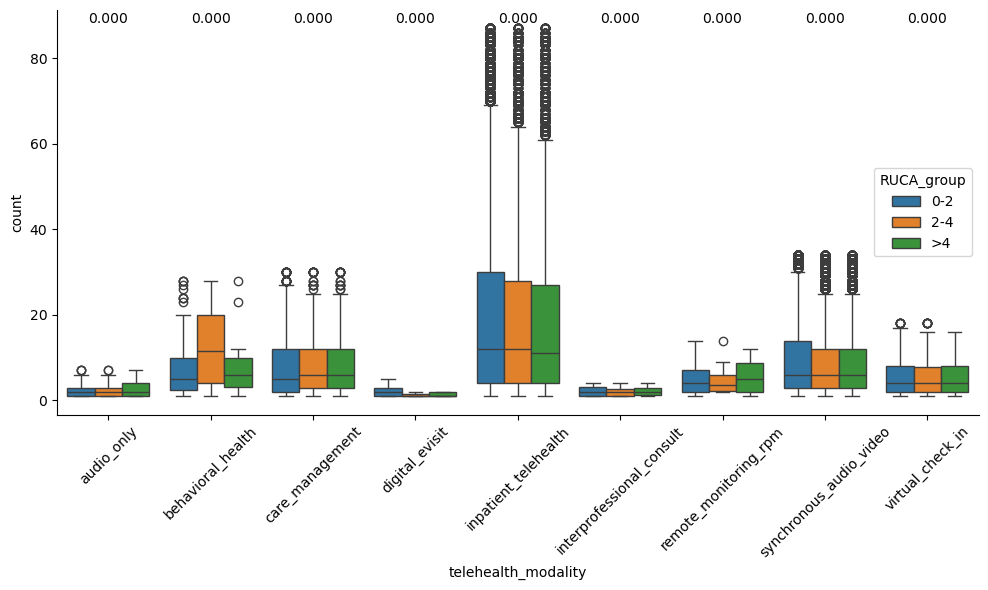

In [171]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


for col_ in ['sex','ethnicity','race','age_group','RUCA_group']:

    # Compute per-patient total per modality
    cohort_wide = cohort_long.groupby(['patient_id', col_, 'telehealth_modality'])['count'].mean().reset_index()
    cohort_wide = cohort_wide[cohort_wide[col_]!='Unknown']
    
    def remove_outliers_iqr(df, group_col, value_col):
        def _filter(group):
            q1 = group[value_col].quantile(0.25)
            q3 = group[value_col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
        
        return df.groupby(group_col, group_keys=False).apply(_filter)
    
    cohort_wide = remove_outliers_iqr(cohort_wide, 'telehealth_modality', 'count')
    
    # Calculate p-values
    # modality_pvals = {}
    # for modality in cohort_wide['telehealth_modality'].unique():
    #     male_counts = cohort_wide[(cohort_wide['telehealth_modality'] == modality) & (cohort_wide[col_] == 'M')]['count']
    #     female_counts = cohort_wide[(cohort_wide['telehealth_modality'] == modality) & (cohort_wide[col_] == 'F')]['count']
    #     if len(male_counts) > 0 and len(female_counts) > 0:
    #         stat, p = mannwhitneyu(male_counts, female_counts, alternative='two-sided')
    #         modality_pvals[modality] = p
    
    from scipy.stats import kruskal
    
    # Use 'race' or any other column with >2 categories
    # if col_ = 'race'
    modality_pvals = {}
    for modality in cohort_wide['telehealth_modality'].unique():
        data = []
        for group in cohort_wide[col_].dropna().unique():
            group_counts = cohort_wide[(cohort_wide['telehealth_modality'] == modality) & (cohort_wide[col_] == group)]['count']
            if len(group_counts) > 0:
                data.append(group_counts)
    
        if len(data) == 2:  # Kruskal-Wallis requires at least 2 groups with data
            stat, p = mannwhitneyu(*data, alternative='two-sided')
        elif len(data) > 2:
            stat, p = kruskal(*data)
            p = 0
        else:
            print(len(data))
        modality_pvals[modality] = p
    
    
    # Create boxenplot
    plt.figure(figsize=(10, 6))
    # ax = sns.boxenplot(data=cohort_wide, x='telehealth_modality', y='count', hue=col_) 
    # , log_scale=True
    # ax = sns.violinplot(data=cohort_wide, x='telehealth_modality', y='count', hue=col_)
    ax = sns.boxplot(data=cohort_wide, x='telehealth_modality', y='count', hue=col_)
    
    # plt.yscale('log')
    # plt.title('Average Telehealth Use per Patient by Modality and Sex (with p-values)')
    plt.xticks(rotation=45)
    
    dx = 1./len(th_cols)
    # Annotate p-values above each group
    for i, modality in enumerate(sorted(cohort_wide['telehealth_modality'].unique())):
        pval = modality_pvals.get(modality)
        if pval is not None:
            x = i*dx+dx/2
            # y = cohort_wide[cohort_wide['telehealth_modality'] == modality]['count'].max() * 1.5
            ax.text(x, 0.96, f"{pval:.3f}", ha='center', va='bottom',
                        transform=ax.transAxes, fontsize=10, color='black')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()


In [127]:
cohort_long

,patient_id,sex,race,ethnicity,age_group,telehealth_modality,count
1248,#wczC,F,Unknown,Unknown,75+,audio_only,21.0
2136,0gs4,F,Unknown,Unknown,<65,audio_only,2.0
6028,3guS,M,Unknown,Unknown,<65,audio_only,1.0
6577,4Q1AB,F,Unknown,Unknown,65–74,audio_only,4.0
6996,4gWF,F,Unknown,Unknown,75+,audio_only,1.0
...,...,...,...,...,...,...,...
3701432,yApcC,F,Unknown,Not Hispanic or Latino,<65,virtual_check_in,8.0
3702033,ygGFC,F,White,Not Hispanic or Latino,75+,virtual_check_in,25.0
3702487,ywQWD,M,White,Not Hispanic or Latino,65–74,virtual_check_in,4.0
3702549,yw_F,F,Unknown,Unknown,75+,virtual_check_in,15.0


In [67]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(cohort_long['sex'], cohort_long['telehealth_modality'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square p-value (sex vs modality): {p:.4f}")


Chi-square p-value (sex vs modality): 0.0000


In [29]:
df_px.shape
# 145249375 
# 108748830

(102323794, 6)

In [23]:
uuu = df_px['code_px'].unique().tolist()

In [ ]:
# synchronous_telehealth
# virtual_check_in
# digital_evisits
# telephone_e_m
# rpm
# rtm
# interprofessional_consults
# behavioral_health_integration
# chronic_care_management
# principal_care_management

In [ ]:
import pandas as pd
from datetime import timedelta

# 1. LOAD TABLES ----------------------------------------------------------------
diag   = pd.read_csv("diagnosis.csv",         parse_dates=['date'])
proc   = pd.read_csv("procedure.csv",         parse_dates=['date'])
cost_m = pd.read_csv("cost_medical.csv",      parse_dates=['service_date'])
pat    = pd.read_csv("patient.csv")           # for demographics

# 2. STROKE INDEX ENCOUNTER -----------------------------------------------------
STROKE_ICD10 = tuple(["I63", "I61", "G45"])  # tweak as needed
stroke_idx = (diag.code_system.eq("ICD10") &
              diag.code.str.startswith(STROKE_ICD10))

index_enc = (diag[stroke_idx]
             .groupby("patient_id")
             .date.min()                     # first stroke dx ⇒ index admit date
             .rename("index_admit"))

# 3. DISCHARGE DATE VIA COST TABLE ---------------------------------------------
# TriNetX labels inpatient claims; treat consecutive inpatient service_dates
# as one encounter and take the max date as discharge.
inpt = cost_m[cost_m.claim_type.str.contains("inpatient", case=False, na=False)]

disch = (inpt.merge(index_enc, on="patient_id")
              .query("service_date >= index_admit")
              .assign(svc_shift=lambda d: d.groupby("patient_id").service_date.diff().dt.days.fillna(0))
              .assign(new_enc=lambda d: (d.svc_shift > 1).cumsum())
              .groupby(["patient_id", "new_enc"])
              .agg(admit_date=('service_date','min'),
                   disch_date=('service_date','max'))
              .reset_index(drop=True))

# keep the episode that matches the index_admit date ± 1 day
idx_episode = (disch.merge(index_enc, on="patient_id")
                    .loc[lambda d: (d.admit_date - d.index_admit).abs().dt.days <= 1]
                    .drop(columns='index_admit'))


In [ ]:
# YOUR curated CPT/HCPCS lists  ------------------------
# VIDEO = {...}  # e.g. {"99201-95", "99202-95", ...}
# PHONE = {...}  # {"99441", "99442", ...}
# TELESTROKE = {...}  # {"G0425","G0426","G0", ...}
# RPM = {...}
# STORE_FWD = {...}

# ----------------------- TELE-HEALTH CODE SETS -----------------------
VIDEO = {
    # Outpatient E/M – NEW patient
    "99202-95","99203-95","99204-95","99205-95",
    # Outpatient E/M – ESTABLISHED patient
    "99212-95","99213-95","99214-95","99215-95",
    # Outpatient consults
    "99242-95","99243-95","99244-95","99245-95",
    # Inpatient / observation E&M (used by some hubs)
    "99221-95","99222-95","99223-95","99231-95","99232-95","99233-95"
}

PHONE = {
    # Legacy telephone-only E/M (valid through 2024 claims)
    "99441","99442","99443",
    "98966","98967","98968",
    # New 2025 synchronous audio-only E/M family
    "98008","98009","98010","98011",   # new patient, ≥10 min audio
    "98012","98013","98014","98015"    # established patient
}

TELESTROKE = {
    # Emergency / critical-care telestroke consults
    "G0425","G0426","G0427",           # ED/initial inpatient 30–70 min
    # Follow-up inpatient tele-neurology consults
    "G0406","G0407","G0408"
    # (You will also see modifier **G0** on ordinary E/M codes; TriNetX
    #  seldom stores modifiers separately, so focus on the G-codes.)
}

RPM = {
    "99453","99454",                   # device set-up & 30-day supply
    "99457","99458",                   # 20-min interactive mgmt, add-on
    "99473","99474",                   # self-measured BP: training + 30-day
    "99091"                            # physiologic data ≥30 min review
}

STORE_FWD = {
    "G2010","G2250","G2251",           # remote image/video eval + follow-up
    "99421","99422","99423",           # online digital E/M (physician)
    "98970","98971","98972"            # online digital E/M (non-physician)
}
# ---------------------------------------------------------------------

def detect_mod(row):
    c = row.code
    if c in VIDEO:        return "video"
    if c in PHONE:        return "phone"
    if c in TELESTROKE:   return "telestroke"
    if c in RPM:          return "rpm"
    if c in STORE_FWD:    return "storefwd"
    return None

tele = (proc.merge(idx_episode[['patient_id','admit_date','disch_date']], on="patient_id")
             .query("admit_date <= date <= disch_date + @timedelta(days=1)")
             .assign(mod=detect_mod)
             .dropna(subset=['mod'])
             .sort_values("date")
             .groupby("patient_id").mod.first())         # first modality

idx_episode = idx_episode.merge(tele.rename("modality"), on="patient_id", how="left")


In [ ]:
# identify any inpatient/ED re-hospitalisation within 30 days of discharge
rehosp = (inpt                  # same inpatient claim table
          .merge(idx_episode[['patient_id','disch_date']], on='patient_id')
          .query("service_date > disch_date & service_date <= disch_date + @timedelta(days=30)")
          .groupby("patient_id").service_date.min()
          .rename("readmit_date"))

idx_episode = idx_episode.assign(readmit_30 = idx_episode.patient_id.isin(rehosp.index).astype(int))


In [ ]:
# age, sex, race, comorbidities (Charlson components)
idx_episode = (idx_episode.merge(pat[['patient_id','sex','race','ethnicity','year_of_birth']],
                                 on='patient_id')
                            .assign(age_yrs = 2025 - idx_episode.year_of_birth))
# Example Charlson: congestive heart failure ICD-10 codes I50*
CHF = diag.code.str.startswith("I50") & (diag.date <= idx_episode.disch_date.max())
chf_pt = diag[CHF].patient_id.unique()
idx_episode['chf'] = idx_episode.patient_id.isin(chf_pt).astype(int)
# repeat for other Charlson elements …


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# A. propensity for any tele-health vs none ------------------------------
idx_episode['any_tele'] = idx_episode.modality.notna().astype(int)

X_cols = ['age_yrs','sex','race','ethnicity','chf', ...]  # add NIHSS if available
y = idx_episode['any_tele']

pipe = Pipeline([
    ("scale", ColumnTransformer([("num", StandardScaler(), ['age_yrs']),
                                 ("cat", "passthrough", ['sex','race','ethnicity','chf', ...])])),
    ("clf", LogisticRegression(max_iter=1000, solver='lbfgs'))
]).fit(idx_episode[X_cols], y)

ps = pipe.predict_proba(idx_episode[X_cols])[:,1]
idx_episode['w'] = np.where(idx_episode.any_tele==1, 1-ps, ps)          # overlap weights
idx_episode['w'] /= idx_episode['w'].mean()                             # stabilise

# B. weighted outcome model ----------------------------------------------
import statsmodels.api as sm
logit_model = sm.GLM(idx_episode.readmit_30,
                     sm.add_constant(idx_episode.any_tele),
                     family=sm.families.Binomial(),
                     freq_weights=idx_episode.w).fit()

print(logit_model.summary())
